In [210]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import re
import nltk
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time 


In [211]:
df_tweet = pd.read_csv("Tweet.csv")

In [212]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   tweet_id     int64 
 1   writer       object
 2   post_date    int64 
 3   body         object
 4   comment_num  int64 
 5   retweet_num  int64 
 6   like_num     int64 
dtypes: int64(5), object(2)
memory usage: 198.6+ MB


In [213]:
df_tweet.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [214]:
df_company_tweet = pd.read_csv("Company_Tweet.csv")

In [215]:
df_company_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
dtypes: int64(1), object(1)
memory usage: 66.2+ MB


In [216]:
df_company_tweet.head()

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL


In [217]:
tweets = pd.merge(df_company_tweet,df_tweet,on= "tweet_id", how = "inner")

In [218]:
tweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


In [219]:
def datasetInfo(dataset):
    print(f" Dataset Information and type \n {dataset.info()}")
    print("--------------------------------------------------------\n\n Data Types: ")
    print(dataset.dtypes)
    print("--------------------------------------------------------\n\n Rows and Columns: ")
    print(dataset.shape)
    print("--------------------------------------------------------\n\n Column Names: ")
    print(dataset.columns)
    print("--------------------------------------------------------\n\n Null Values: ")
    print(dataset.apply(lambda x: sum(x.isnull()) / len(dataset)))
    print("--------------------------------------------------------\n\n Unique Values: ")
    print(dataset.nunique())
    print("--------------------------------------------------------\n\n Describe: ")
    print(dataset.describe())

In [220]:
datasetInfo(tweets)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
 2   writer         object
 3   post_date      int64 
 4   body           object
 5   comment_num    int64 
 6   retweet_num    int64 
 7   like_num       int64 
dtypes: int64(5), object(3)
memory usage: 297.8+ MB
 Dataset Information and type 
 None
--------------------------------------------------------

 Data Types: 
tweet_id          int64
ticker_symbol    object
writer           object
post_date         int64
body             object
comment_num       int64
retweet_num       int64
like_num          int64
dtype: object
--------------------------------------------------------

 Rows and Columns: 
(4336445, 8)
--------------------------------------------------------

 Column Names: 
Index(['tweet_id', 'ticker_symbol', 'writer', 'post_date', 'body',
       'comment_num

After Merging Remove the dataframes that do not have ticker_symbols

In [221]:
tweets.dropna(inplace = True)

Convert our post_date time in seconds to date_time

In [222]:
tweets['post_date'] = pd.to_datetime(tweets["post_date"],utc = False , unit = 's',).dt.normalize()
tweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


We need our a training set and a testing set for the prediction of Neutral or Opinionated Tweets

In [223]:
tweets.sort_values(by = "comment_num" , ascending  = False, inplace = True)
tweets


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0
...,...,...,...,...,...,...,...,...
1488123,1060565704389378055,AAPL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1
1488124,1060565704389378055,GOOGL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1
1488125,1060566279818366977,AAPL,jordanladz,2018-11-08,Get audible updates with this new application....,0,0,0
1488126,1060566346763849735,AAPL,CompoundFreedom,2018-11-08,Apple Opens First Store in Thailand Saturday h...,0,0,0


## First Find the sum of all the activities in the tweet post

In [224]:
tweets["tweet_activity"] = tweets["comment_num"] + tweets["like_num"] + tweets["retweet_num"]
tweets

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0,442
...,...,...,...,...,...,...,...,...,...
1488123,1060565704389378055,AAPL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1,1
1488124,1060565704389378055,GOOGL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1,1
1488125,1060566279818366977,AAPL,jordanladz,2018-11-08,Get audible updates with this new application....,0,0,0,0
1488126,1060566346763849735,AAPL,CompoundFreedom,2018-11-08,Apple Opens First Store in Thailand Saturday h...,0,0,0,0


## Filter Tweets that are >= 50 activities

In [225]:
filterTweets = tweets.loc[tweets["tweet_activity"] > 50]

In [226]:
filterTweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0,442


In [227]:
datasetInfo(filterTweets)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41625 entries, 3786974 to 1488017
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        41625 non-null  int64         
 1   ticker_symbol   41625 non-null  object        
 2   writer          41625 non-null  object        
 3   post_date       41625 non-null  datetime64[ns]
 4   body            41625 non-null  object        
 5   comment_num     41625 non-null  int64         
 6   retweet_num     41625 non-null  int64         
 7   like_num        41625 non-null  int64         
 8   tweet_activity  41625 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 3.2+ MB
 Dataset Information and type 
 None
--------------------------------------------------------

 Data Types: 
tweet_id                   int64
ticker_symbol             object
writer                    object
post_date         datetime64[ns]
bo

### Data Cleaning and Tokenization of text body

In [228]:
from nltk.corpus import stopwords

def removeStopWords(df):
    finalList = []
    stop_words = set(stopwords.words('english'))
    for word in df:
        if word not in stop_words:
            finalList.append(word)
    df = finalList
    return df

In [229]:
from nltk.stem.porter import *

def stem_text(text):
    
    stemmer = PorterStemmer()
   
    return [stemmer.stem(word) for word in text]

In [230]:
def lemmatised_text(text):
    lemmatiser = nltk.stem.WordNetLemmatizer()
    return [lemmatiser.lemmatize(word) for word in text]

In [231]:
import pandas as pd
import re



def clean_dataframe_text(df, column,lemma):
    
    # Define regex pattern to match URLs
    url_pattern = r"https?://\S+"
    
    # Remove URLs from text column
    df[column] = df[column].str.replace(url_pattern, "", regex=True)
    
    # Remove any non-alphanumeric characters and replace them with spaces
    df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
    
    # Replace 's with 'is' or 'has'
    df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'s", lambda m: 'is' if m.group(1) in ['he', 'she', 'it'] else 'has', x))
    
    # Remove any non-alphanumeric characters and replace them with spaces
    df[column] = df[column].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    
    # Replace any consecutive whitespace characters with a single space
    df[column] = df[column].apply(lambda x: re.sub(r'\s+', ' ', x))
    
    # Remove not word characters
    df[column] = df[column].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    
       
    # Remove digits 
    df[column] = df[column].apply(lambda x: re.sub(r'\d+', '', x))
    
    # Convert the string in lower
    df[column] = df[column].str.lower()
    
    # Tokenised the words
    df[column]  = df[column].apply(lambda x : nltk.word_tokenize(x))

    # Remove stopwords from the NLTK stopword list
    df[column] = df[column].apply(lambda x : removeStopWords(x))
    
    if lemma:
    # Porter Stemmer
        df[column] = df[column].apply(lambda x : lemmatised_text(x))
    else:
        df[column] = df[column].apply(lambda x : stem_text(x))
    #concatenate the tokenised list into string
    df[column] = df[column].apply(lambda x: ' '.join(x))
    
      
    return df

In [232]:
#False: Stemming True: Lemmatization
filterTweets = clean_dataframe_text(filterTweets,"body",False)
filterTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2573604085.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace(url_pattern, "", regex=True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2573604085.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2573604085.py:18: SettingWithCo

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442


In [233]:
filterTweetsLemma = clean_dataframe_text(filterTweets,"body",True)
filterTweetsLemma.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2573604085.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace(url_pattern, "", regex=True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2573604085.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2573604085.py:18: SettingWithCo

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442


In [234]:
filterTweets["body"].head()

3786974    id like point right right moment elonmusk go f...
4112626    tesla save month ga ten year take save put bal...
4306536    tesla featur request threadfeel free repli ill...
2823018           sell book versu sell whatev fuck want amzn
4182686    think basic financi insan buy anyth except ele...
Name: body, dtype: object

### Tweet EDA

In [235]:
filterTweets["writer"].describe()


count           41625
unique           2797
top       TESLAcharts
freq             2212
Name: writer, dtype: object

### Writer Data Exploration

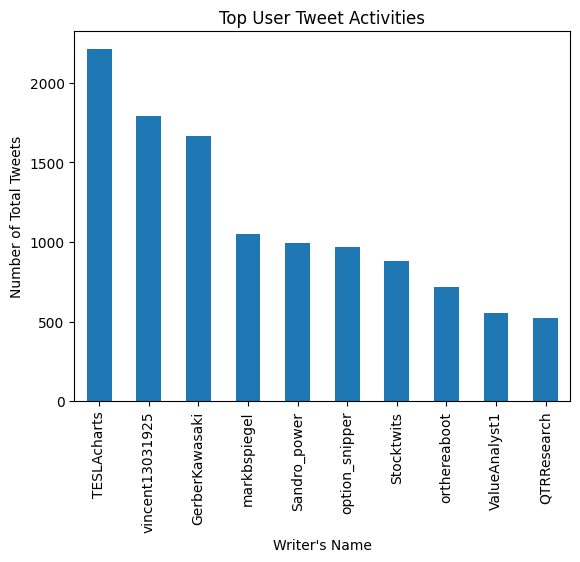

In [236]:

counts = filterTweets["writer"].value_counts(ascending= False)
countsFilter = counts[:10]
countsFilter.plot(kind="bar")

plt.title("Top User Tweet Activities")
plt.ylabel("Number of Total Tweets")
plt.xlabel("Writer's Name")
plt.show()

Graph above shows the top writers that are active and have >100 posts

<AxesSubplot: ylabel='ticker_symbol'>

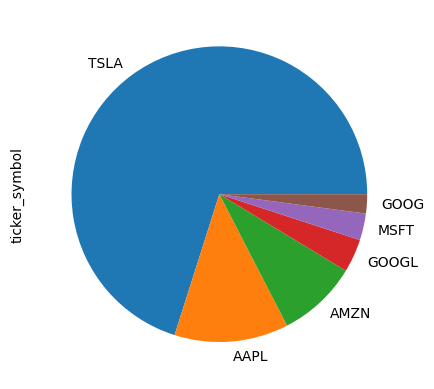

In [237]:

counts = filterTweets["ticker_symbol"].value_counts()
counts.plot(kind="pie")

Notice that there are more TSLA tweets in the dataset.

### Active Tweets dates

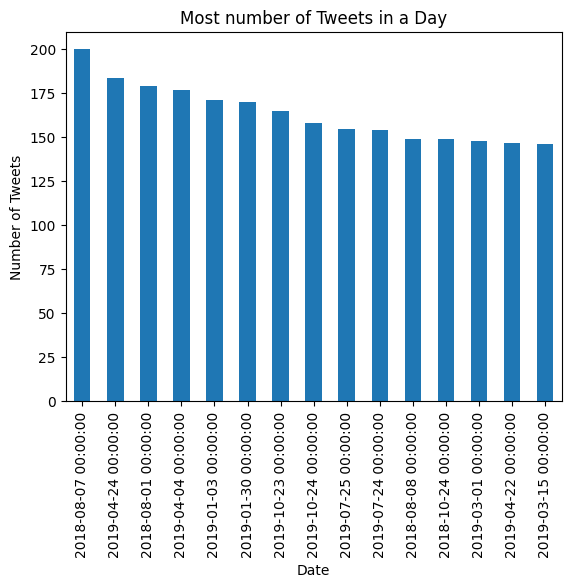

In [238]:
count = filterTweets["post_date"].value_counts(ascending = False)
count
filterCounts = count[:15]
filterCounts.plot(kind = "bar")
plt.title("Most number of Tweets in a Day")
plt.ylabel("Number of Tweets")
plt.xlabel("Date")
plt.show()

Above bar graphs shows the highest tweets in the respective days

### Word Cloud of Tweets

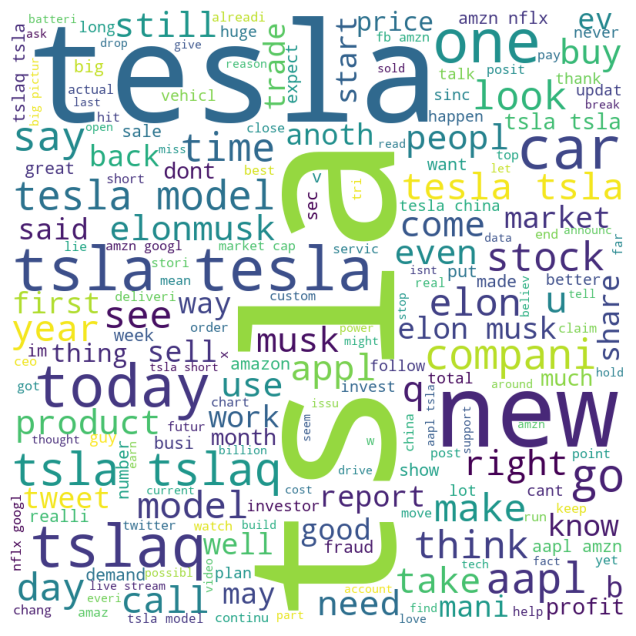

In [239]:
text = " ".join(filterTweets["body"])
wordcloud = WordCloud(width = 800, height = 800, background_color='white', max_words = 200)
wordcloud.generate(text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

From the word cloud we can tell that TSLA/TESLA and AAPL are common tweets in Twitter

# Polarity Detection

### Import Sentiment Analyser from NLTK

In [240]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [241]:
analyser = SentimentIntensityAnalyzer()

In [242]:
def getSentiment(body):
    analyser = SentimentIntensityAnalyzer()
    
    assert body is not None
    sentimentAnalysis = analyser.polarity_scores(body)
    score = sentimentAnalysis['compound']
    
    if (score >= 0.05):
        return "Positive"
    elif (score < 0.05 and score > -0.05):
        return "Neutral"
    elif (score <= -0.05):
        return "Negative"
    
    print(score)
    

### Creating Sentiment Analysis for different datasets

In [243]:
filterTweets['sentiment'] = filterTweets['body'].apply(lambda x : getSentiment(x))

filterTweets.head()


C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\3123628082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweets['sentiment'] = filterTweets['body'].apply(lambda x : getSentiment(x))


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,Positive
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,Positive
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,Positive
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,Negative
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,Positive


In [244]:
filterTweetsLemma['sentiment'] = filterTweets['body'].apply(lambda x : getSentiment(x))

filterTweetsLemma.head()


C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2992052023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweetsLemma['sentiment'] = filterTweets['body'].apply(lambda x : getSentiment(x))


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,Positive
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,Positive
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,Positive
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,Negative
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,Positive


### Testing out TextBlob Sentimental Analysis

In [245]:
from textblob import TextBlob

In [246]:
# Function to use TextBlob (Sentimental Analysis [Objectivity & Polarity])

def add_sentiment_scores_blob(df, text_column, polarity_threshold = 0.0 , subjectivity_threshold = 0.5):
    # Compute polarity and subjectivity scores for each row in the specified text column
    scores = df[text_column].apply(lambda x: TextBlob(x).sentiment)
    
    # Add two new columns to the DataFrame for the polarity and subjectivity scores
    df['blob_polarity'] = scores.apply(lambda x: x.polarity)
    df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
    
    # Convert polarity score to class (positive, neutral, or negative) based on the specified threshold
    df['blob_polarity'] = df['blob_polarity'].apply(lambda x: 'Positive' if x > polarity_threshold else 'Negative' if x < -polarity_threshold else 'Neutral')
    
    # Convert subjectivity score to class (subjective or objective) based on the specified threshold
    df['blob_subjectivity'] = df['blob_subjectivity'].apply(lambda x: 'Subjective' if x > subjectivity_threshold else 'Objective')
    
    return df
    
    

In [247]:
add_sentiment_scores_blob(filterTweets,"body", 0.0, 0.5)
filterTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2951990553.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_polarity'] = scores.apply(lambda x: x.polarity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2951990553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2951990553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,Positive,Positive,Subjective
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,Positive,Positive,Objective
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,Positive,Negative,Subjective
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,Negative,Negative,Subjective
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,Positive,Negative,Objective


In [248]:
add_sentiment_scores_blob(filterTweetsLemma,"body", 0.0, 0.5)
filterTweetsLemma.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2951990553.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_polarity'] = scores.apply(lambda x: x.polarity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2951990553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2951990553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,Positive,Positive,Subjective
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,Positive,Positive,Objective
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,Positive,Negative,Subjective
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,Negative,Negative,Subjective
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,Positive,Negative,Objective


### Convert Positive, Negative and Neutral to numeral labels and Subjectivity

In [249]:
sentiment_map = {"Positive": 1, "Negative": 0, "Neutral": 2}
subjectivity_mapping = {"Subjective": 1, "Objective": 0}


In [250]:
filterTweets["sentiment"].replace(sentiment_map, inplace = True)
filterTweets["blob_polarity"].replace(sentiment_map, inplace = True)
filterTweets["blob_subjectivity"].replace(subjectivity_mapping, inplace = True)
filterTweets.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\1162442850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweets["sentiment"].replace(sentiment_map, inplace = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\1162442850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweets["blob_polarity"].replace(sentiment_map, inplace = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\1162442850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,1,1,1
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,1,1,0
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,1,0,1
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,0,0,1
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,1,0,0


In [251]:
filterTweetsLemma["sentiment"].replace(sentiment_map, inplace = True)
filterTweetsLemma["blob_polarity"].replace(sentiment_map, inplace = True)
filterTweetsLemma.head()

C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2292899471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweetsLemma["sentiment"].replace(sentiment_map, inplace = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_40152\2292899471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweetsLemma["blob_polarity"].replace(sentiment_map, inplace = True)


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,1,1,1
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,1,1,0
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,1,0,1
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,0,0,1
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,1,0,0



### Separating Neutral Sentiments and Opinionated Sentiments for NLTK Analysis

In [252]:
opinionatedTweets = filterTweets.loc[filterTweets["sentiment"]!= 2]
opinionatedTweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,1,1,1
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,1,1,0
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,1,0,1
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,0,0,1
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,1,0,0


In [253]:
opinionatedTweetsLemma = filterTweetsLemma.loc[filterTweetsLemma["sentiment"]!= 2]
opinionatedTweetsLemma.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,1,1,1
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,1,1,0
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,1,0,1
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,0,0,1
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,1,0,0


In [254]:
X_opinionated = filterTweets["body"].values #["ticker_symbol","writer" , "body"]
y_opinionated = filterTweets["sentiment"].values
X_train_opinionated, X_test_opinionated, y_train_opinionated, y_test_opinionated = train_test_split(
    X_opinionated, y_opinionated, test_size=0.20, random_state=0)

In [255]:
X_opinionated_lemma = filterTweets["body"].values #["ticker_symbol","writer" , "body"]
y_opinionated_lemma = filterTweets["sentiment"].values
X_train_opinionated_lemma, X_test_opinionated_lemma, y_train_opinionated_lemma, y_test_opinionated_lemma = train_test_split(
    X_opinionated_lemma, y_opinionated_lemma, test_size=0.20, random_state=0)

In [256]:
neutralTweets = filterTweets.loc[filterTweets["sentiment"] == 2]
neutralTweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment,blob_polarity,blob_subjectivity
4002464,1082182633948295168,TSLA,vincent13031925,2019-01-07,tesla ceo elonmusk shanghai mayor ying yong te...,318,0,0,318,2,2,0
4142690,1126183436144795649,TSLA,TeslaNY,2019-05-08,test product car ever crack second mph tesla s...,280,0,0,280,2,2,0
4301361,1197894016358060032,TSLA,carlquintanilla,2019-11-22,caption pleasetsla cybertruckvia teflongeek,276,27,201,504,2,2,0
1336141,993863874406420481,AAPL,philstockworld,2018-05-08,trillion dollar tuesday appl close histor valu...,213,489,387,1089,2,2,0
1568450,1087700913752600576,AAPL,jimcramer,2019-01-22,hatr aapl reject idea help custom healthcar wa...,204,66,757,1027,2,2,0


In [257]:
neutralTweetsLemma = filterTweetsLemma.loc[filterTweetsLemma["sentiment"] == 2]
neutralTweetsLemma.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment,blob_polarity,blob_subjectivity
4002464,1082182633948295168,TSLA,vincent13031925,2019-01-07,tesla ceo elonmusk shanghai mayor ying yong te...,318,0,0,318,2,2,0
4142690,1126183436144795649,TSLA,TeslaNY,2019-05-08,test product car ever crack second mph tesla s...,280,0,0,280,2,2,0
4301361,1197894016358060032,TSLA,carlquintanilla,2019-11-22,caption pleasetsla cybertruckvia teflongeek,276,27,201,504,2,2,0
1336141,993863874406420481,AAPL,philstockworld,2018-05-08,trillion dollar tuesday appl close histor valu...,213,489,387,1089,2,2,0
1568450,1087700913752600576,AAPL,jimcramer,2019-01-22,hatr aapl reject idea help custom healthcar wa...,204,66,757,1027,2,2,0


### Splitting up data for Prediction using ensemble machine learning models For Blob Subjectivity and Polarity Analysis

In [258]:
X = filterTweets["body"].values #["ticker_symbol","writer" , "body"]
y = filterTweets["blob_polarity"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0)

In [259]:
X_lemma = filterTweetsLemma["body"].values #["ticker_symbol","writer" , "body"]
y_lemma = filterTweetsLemma["blob_polarity"].values
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(
    X_lemma, y_lemma, test_size=0.20, random_state=0)

In [260]:
X_subj = filterTweets["body"].values #["ticker_symbol","writer" , "body"]
y_subj = filterTweets["blob_subjectivity"].values
X_train_subj, X_test_subj, y_train_subj, y_test_subj = train_test_split(
    X_subj, y_subj, test_size=0.20, random_state=0)

In [261]:
X_subj_lemma = filterTweetsLemma["body"].values #["ticker_symbol","writer" , "body"]
y_subj_lemma = filterTweetsLemma["blob_subjectivity"].values
X_train_subj_lemma, X_test_subj_lemma, y_train_subj_lemma, y_test_subj_lemma = train_test_split(
    X_subj_lemma, y_subj_lemma, test_size=0.20, random_state=0)

In [262]:
X_train[0]


'instead get annoy press ignor jeff dahn research million mile batteri ive decid enjoy think year think back way help acceler transit clean transportationenergytesla tsla'

In [263]:
X_test[0]

'great writeup potenti recoveri bondhold bankruptci best luck think bull think equiti worth cent tslaq'

In [264]:
y_train[0]


1

In [265]:
y_test[0]


1

In [266]:
filterTweets["sentiment"].value_counts()

1    16663
2    14883
0    10079
Name: sentiment, dtype: int64

In [273]:
def metric_report(y_test,y_pred,time):
    accuracy = accuracy_score(y_test,y_pred)
    fmeasure = f1_score(y_test,y_pred, average = "weighted")
    recall = recall_score(y_test, y_pred, average = "weighted")
    precision = precision_score(y_test, y_pred, average = "weighted")
    print(f"The accuracy of the Model is {accuracy}")
    print(f"The F-Score of the Model is {fmeasure}")
    print(f"The Recall of the Model is {recall}")
    print(f"The precision of the Model is {precision}")
    print(f"The time taken for the Model is {time} seconds")
    return {"accuracy": accuracy,
            "fmeasure": fmeasure,
            "recall": recall,
            "precision": precision,
            "time": time}

### Vectorise and TFIDF train and test datas

In [268]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [269]:
# Create Count Vectorizer (TF)
vectoriser = CountVectorizer()

# For opinionated Dataset and blob analysis dataset that have been stemmed
X_train_opinionated_vec = vectoriser.fit_transform(X_train_opinionated)
X_test_opinionated_vec = vectoriser.transform(X_test_opinionated)

X_train_vec = vectoriser.fit_transform(X_train)
X_test_vec = vectoriser.transform(X_test)

# For opinionated Dataset and blob analysis dataset that have been lemmatised
X_train_opinionated_lemma_vec = vectoriser.fit_transform(X_train_opinionated_lemma)
X_test_opinionated_lemma_vec= vectoriser.transform(X_test_opinionated_lemma)

X_train_lemma_vec = vectoriser.fit_transform(X_train_lemma)
X_test_lemma_vec = vectoriser.transform(X_test_lemma)

# For Subjectivity Blob Analysis 
X_train_subj_vec = vectoriser.fit_transform(X_train_subj)
X_test_subj_vec = vectoriser.transform(X_test_subj)

X_train_subj_lemma_vec = vectoriser.fit_transform(X_train_subj_lemma)
X_test_subj_lemma_vec = vectoriser.transform(X_test_subj_lemma)


# Create TFID Vectorizer 
vectoriser_tfidf = TfidfVectorizer()
# For opinionated Dataset and blob analysis dataset that have been stemmed
X_train_opinionated_tfidf = vectoriser_tfidf.fit_transform(X_train_opinionated)
X_test_opinionated_tfidf = vectoriser_tfidf.transform(X_test_opinionated)

X_train_tfidf = vectoriser_tfidf.fit_transform(X_train)
X_test_tfidf = vectoriser_tfidf.transform(X_test)
# For opinionated Dataset and blob analysis dataset  that have been lemmatised
X_train_opinionated_lemma_tfidf = vectoriser_tfidf.fit_transform(X_train_opinionated_lemma)
X_test_opinionated_lemma_tfidf = vectoriser_tfidf.transform(X_test_opinionated_lemma)

X_train_lemma_tfidf = vectoriser_tfidf.fit_transform(X_train_lemma)
X_test_lemma_tfidf = vectoriser_tfidf.transform(X_test_lemma)

# For Subjectivity Blob Analysis 
X_train_subj_tfidf = vectoriser_tfidf.fit_transform(X_train_subj)
X_test_subj_tfidf = vectoriser_tfidf.transform(X_test_subj)


X_train_subj_lemma_tfidf = vectoriser_tfidf.fit_transform(X_train_subj_lemma)
X_test_subj_lemma_tfidf = vectoriser_tfidf.transform(X_test_subj_lemma)




## Machine Learnining Model for NLTK Sentimental Analysis

## Polarity Detection

### Create a Naive_bayes Model

#### Vectorised Stemmed and Lemmatised Dataset

In [270]:
metric_results = {}

In [277]:

# Stemmed Dataset
# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
start_time = time.time()
clf.fit(X_train_opinionated_vec, y_train_opinionated)

# Make predictions on test data
y_pred = clf.predict(X_test_opinionated_vec)
end_time = time.time()
time_taken = end_time - start_time
# Evaluate the model using accuracy score
metric_results["stemmed_nltk_nb_model_vec"] = metric_report(y_test_opinionated,y_pred,time_taken)

The accuracy of the Model is 0.7054654654654655
The F-Score of the Model is 0.7018643848895197
The Recall of the Model is 0.7054654654654655
The precision of the Model is 0.7332712171509903
The time taken for the Model is 0.008980512619018555 seconds


In [278]:
# Lemmatised Dataset
# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
start_time = time.time()
clf.fit(X_train_opinionated_lemma_vec, y_train_opinionated_lemma)

# Make predictions on test data
y_pred = clf.predict(X_test_opinionated_lemma_vec)
end_time = time.time()
time_taken = end_time - start_time
# Evaluate the model using accuracy score

metric_results["lemmatised_nltk_nb_model_vec"] = metric_report(y_test_opinionated_lemma,y_pred,time_taken)

The accuracy of the Model is 0.7054654654654655
The F-Score of the Model is 0.7018643848895197
The Recall of the Model is 0.7054654654654655
The precision of the Model is 0.7332712171509903
The time taken for the Model is 0.00897669792175293 seconds


### TFIDF Stemmed and Lemmatised Dataset

In [279]:
# Stemmed Dataset
# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
start_time = time.time()
clf.fit(X_train_opinionated_tfidf, y_train_opinionated)

# Make predictions on test data
y_pred = clf.predict(X_test_opinionated_tfidf)
end_time = time.time()
time_taken = end_time - start_time

# Evaluate the model using accuracy score
metric_results["stemmed_nltk_nb_model_tfidf"] = metric_report(y_test_opinionated,y_pred,time_taken)

The accuracy of the Model is 0.6147747747747748
The F-Score of the Model is 0.5855929678555499
The Recall of the Model is 0.6147747747747748
The precision of the Model is 0.734270022612147
The time taken for the Model is 0.01496267318725586 seconds


In [280]:
# Lemmatised Dataset
# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
start_time = time.time()
clf.fit(X_train_opinionated_lemma_tfidf, y_train_opinionated_lemma)

# Make predictions on test data
y_pred = clf.predict(X_test_opinionated_lemma_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
# Evaluate the model using accuracy score
metric_results["lemmatised_nltk_nb_model_tfidf"] = metric_report(y_test_opinionated_lemma,y_pred,time_taken)

The accuracy of the Model is 0.6147747747747748
The F-Score of the Model is 0.5855929678555499
The Recall of the Model is 0.6147747747747748
The precision of the Model is 0.734270022612147
The time taken for the Model is 0.013478279113769531 seconds


### Decision Tree Classifier Model

#### Vectorised Decision Tree

In [281]:
# Stemmed Dataset
clf = DecisionTreeClassifier()
start_time = time.time()
clf.fit(X_train_opinionated_vec,y_train_opinionated)

y_pred = clf.predict(X_test_opinionated_vec)
end_time = time.time()
time_taken = end_time - start_time

metric_results["stemmed_nltk_dt_model_vec"] = metric_report(y_test_opinionated,y_pred, time_taken)


The accuracy of the Model is 0.885045045045045
The F-Score of the Model is 0.8847082066342183
The Recall of the Model is 0.885045045045045
The precision of the Model is 0.8848423347220836
The time taken for the Model is 17.751203298568726 seconds


In [287]:
# Lemmatised Dataset

clf = DecisionTreeClassifier()
start_time =  time.time()
clf.fit(X_train_opinionated_lemma_vec,y_train_opinionated_lemma)

y_pred = clf.predict(X_test_opinionated_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["lemmatised_nltk_dt_model_vec"] = metric_report(y_test_opinionated_lemma,y_pred,time_taken)

The accuracy of the Model is 0.8874474474474474
The F-Score of the Model is 0.8870953461123666
The Recall of the Model is 0.8874474474474474
The precision of the Model is 0.8872023695452472
The time taken for the Model is 18.54646062850952 seconds


#### TFIDF Decision Tree

In [288]:
# Stemmed Dataset
clf = DecisionTreeClassifier()
start_time = time.time()
clf.fit(X_train_opinionated_tfidf,y_train_opinionated)

y_pred = clf.predict(X_test_opinionated_tfidf)
end_time = time.time()
time_taken = end_time - start_time

metric_results["stemmed_nltk_dt_model_tfidf"] = metric_report(y_test_opinionated,y_pred,time_taken)

The accuracy of the Model is 0.8258258258258259
The F-Score of the Model is 0.8233959022439482
The Recall of the Model is 0.8258258258258259
The precision of the Model is 0.8228847425653023
The time taken for the Model is 20.49320411682129 seconds


In [289]:
# Lemmatised Dataset
clf = DecisionTreeClassifier()
start_time = time.time()
clf.fit(X_train_opinionated_lemma_tfidf,y_train_opinionated_lemma)

y_pred = clf.predict(X_test_opinionated_lemma_tfidf)
end_time = time.time()
time_taken = end_time - start_time
metric_results["lemmatised_nltk_dt_model_vec"] = metric_report(y_test_opinionated_lemma,y_pred,time_taken)

The accuracy of the Model is 0.8282282282282283
The F-Score of the Model is 0.8258536594883132
The Recall of the Model is 0.8282282282282283
The precision of the Model is 0.8253945321163726
The time taken for the Model is 20.424840211868286 seconds


### Create a Ensemble Learning Classifier


In [290]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#### Vectoriser Stemmed and Lemmatised Ensemble Learning Classifier

In [291]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

start_time = time.time()
# Train the ensemble classifier
ensemble.fit(X_train_opinionated_vec, y_train_opinionated)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_opinionated_vec)
end_time = time.time()
time_taken = end_time - start_time

# Evaluate the accuracy of the model
metric_results["stemmed_nltk_ensemble_model_vec"] = metric_report(y_test_opinionated,y_pred,time_taken)

The accuracy of the Model is 0.889009009009009
The F-Score of the Model is 0.8866292322005825
The Recall of the Model is 0.889009009009009
The precision of the Model is 0.8891346451607183
The time taken for the Model is 819.756621837616 seconds


In [292]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

start_time =  time.time()
# Train the ensemble classifier
ensemble.fit(X_train_opinionated_lemma_vec, y_train_opinionated_lemma)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_opinionated_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
# Evaluate the accuracy of the model
metric_results["lemmatised_nltk_ensemble_model_vec"] = metric_report(y_test_opinionated_lemma,y_pred,time_taken)

#### TFIDF Stemmed and Lemmatised Ensemble Learning Classifier

In [ ]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
start_time = time.time()

# Train the ensemble classifier
ensemble.fit(X_train_opinionated_tfidf, y_train_opinionated)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_opinionated_tfidf)

end_time = time.time()
time_taken =  end_time - start_time
# Evaluate the accuracy of the model
metric_results["stemmed_nltk_ensemble_model_tfidf"] = metric_report(y_test_opinionated,y_pred,time_taken)

The accuracy of the Model is 0.8791591591591592
The F-Score of the Model is 0.8762039783055441
The Recall of the Model is 0.8791591591591592
The precision of the Model is 0.8798045768571


In [ ]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
start_time = time.time()

# Train the ensemble classifier
ensemble.fit(X_train_opinionated_lemma_tfidf, y_train_opinionated_lemma)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_opinionated_lemma_tfidf)
end_time = time.time()
time_taken =  end_time - start_time

# Evaluate the accuracy of the model
metric_results["lemmatised_nltk_ensemble_model_tfidf"] = metric_report(y_test_opinionated,y_pred,time_taken)

The accuracy of the Model is 0.877957957957958
The F-Score of the Model is 0.8751548347908329
The Recall of the Model is 0.877957957957958
The precision of the Model is 0.8781368317610833


### Support Vector Machine Models


#### SVM for Stemmed and Lemmatised Vectorised Dataset

In [ ]:
# Stemmed Dataset with vectorised
from sklearn import svm
clf = svm.SVC(kernel = "rbf",random_state = 1)
start_time = time.time()
clf.fit(X_train_opinionated_vec,y_train_opinionated)

svm_pred = clf.predict(X_test_opinionated_vec)
end_time = time.time()
time_taken =  end_time - start_time
metric_results["stemmed_nltk_svm_model_vec"] = metric_report(y_test_opinionated,svm_pred,time_taken)

The accuracy of the Model is 0.8646246246246246
The F-Score of the Model is 0.8620136771074409
The Recall of the Model is 0.8646246246246246
The precision of the Model is 0.865907932511726


In [ ]:
# Lemmatised Dataset with vectorised
from sklearn import svm
clf = svm.SVC(kernel = "rbf",random_state = 1)
start_time = time.time()
clf.fit(X_train_opinionated_lemma_vec,y_train_opinionated_lemma)

svm_pred = clf.predict(X_test_opinionated_lemma_vec)
end_time = time.time()
time_taken = end_time - start_time
metric_results["lemmatised_nltk_svm_model_vec"]= metric_report(y_test_opinionated_lemma,svm_pred,time_taken)

The accuracy of the Model is 0.8646246246246246
The F-Score of the Model is 0.8620136771074409
The Recall of the Model is 0.8646246246246246
The precision of the Model is 0.865907932511726


#### SVM for  Stemmed and Lemmatised TFIDF Dataset

In [ ]:
# Stemmed Dataset with TFIDF
from sklearn import svm
clf = svm.SVC(kernel = "rbf",random_state = 1)
start_time = time.time()
clf.fit(X_train_opinionated_tfidf,y_train_opinionated)

svm_pred = clf.predict(X_test_opinionated_tfidf)
end_time = time.time()
time_taken = end_time - start_time
metric_results["stemmed_nltk_svm_model_tfidf"] = metric_report(y_test_opinionated,svm_pred,time_taken)

The accuracy of the Model is 0.8820420420420421
The F-Score of the Model is 0.8802140136957307
The Recall of the Model is 0.8820420420420421
The precision of the Model is 0.8827941980829496


In [ ]:
# Lemmatised Dataset with TFIDF
from sklearn import svm
clf = svm.SVC(kernel = "rbf",random_state = 1)
start_time = time.time()
clf.fit(X_train_opinionated_lemma_tfidf,y_train_opinionated_lemma)

svm_pred = clf.predict(X_test_opinionated_lemma_tfidf)
end_time = time.time()
time_taken = end_time - start_time
metric_results["lemmatised_nltk_svm_model_tfidf"]= metric_report(y_test_opinionated_lemma,svm_pred,time_taken)

The accuracy of the Model is 0.8820420420420421
The F-Score of the Model is 0.8802140136957307
The Recall of the Model is 0.8820420420420421
The precision of the Model is 0.8827941980829496


### Neural Network

#### Lemmatised and Stemmed Dataset that uses Vectorise

In [ ]:
# Stemmed Dataset with vectorised
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
start_time = time.time()

clf.fit(X_train_opinionated_vec,y_train_opinionated)
nn_pred = clf.predict(X_test_opinionated_vec)

end_time = time.time()
time_taken =  end_time - start_time
metric_results["stemmed_nltk_nn_model_vec"] = metric_report(y_test_opinionated,nn_pred,time_taken)


The accuracy of the Model is 0.8974174174174174
The F-Score of the Model is 0.8969378816815435
The Recall of the Model is 0.8974174174174174
The precision of the Model is 0.8968173134889869


In [ ]:
# Lemmatised Dataset with vectorised
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
start_time = time.time()

clf.fit(X_train_opinionated_lemma_vec,y_train_opinionated_lemma)
nn_pred = clf.predict(X_test_opinionated_lemma_vec)

end_time = time.time()
time_taken = end_time - start_time

metric_results["lemmatised_nltk_nn_model_vec"] = metric_report(y_test_opinionated_lemma,nn_pred,time_taken)

The accuracy of the Model is 0.8974174174174174
The F-Score of the Model is 0.8969378816815435
The Recall of the Model is 0.8974174174174174
The precision of the Model is 0.8968173134889869


#### Lemmatised and Stemmed Dataset that uses TFIDF

In [ ]:
# Stemmed Dataset with vectorised
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
start_time = time.time()

clf.fit(X_train_opinionated_tfidf,y_train_opinionated)
nn_pred = clf.predict(X_test_opinionated_tfidf)
end_time = time.time()
time_taken = end_time - start_time

metric_results["stemmed_nltk_nn_model_tfidf"] = metric_report(y_test_opinionated,nn_pred,time_taken)

The accuracy of the Model is 0.8421621621621621
The F-Score of the Model is 0.8418575161484353
The Recall of the Model is 0.8421621621621621
The precision of the Model is 0.8416475578655831


In [ ]:
# Lemmatised Dataset with vectorised
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
start_time = time.time()
clf.fit(X_train_opinionated_lemma_tfidf,y_train_opinionated_lemma)
nn_pred = clf.predict(X_test_opinionated_lemma_tfidf)

end_time = time.time()
time_taken =  end_time - start_time
metric_results["lemmatised_nltk_nn_model_tfidf"] = metric_report(y_test_opinionated_lemma,nn_pred,time_taken)

The accuracy of the Model is 0.8421621621621621
The F-Score of the Model is 0.8418575161484353
The Recall of the Model is 0.8421621621621621
The precision of the Model is 0.8416475578655831


## Doing up Machine Learning Models for TextBlob Analysis

## Subjectivity Prediction

### Naive Bayes ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [ ]:

# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
start_time = time.time()
clf.fit(X_train_subj_vec, y_train_subj)

# Make predictions on test data
y_pred = clf.predict(X_test_subj_vec)
end_time = time.time()
time_taken =  end_time - start_time

# Evaluate the model using accuracy score
metric_results["stemmed_blob_nb_subj_model_vec"] = metric_report(y_test_subj,y_pred,time_taken)

The accuracy of the Model is 0.8518918918918919
The F-Score of the Model is 0.8412657012693125
The Recall of the Model is 0.8518918918918919
The precision of the Model is 0.8455468361536951


In [ ]:

# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
start_time = time.time()
clf.fit(X_train_subj_lemma_vec, y_train_subj_lemma)

# Make predictions on test data
y_pred = clf.predict(X_test_subj_lemma_vec)
end_time = time.time()
time_taken = end_time - start_time
# Evaluate the model using accuracy score
metric_results["lemmatised_blob_nb_subj_model_vec"] = metric_report(y_test_subj_lemma,y_pred,time_taken)

The accuracy of the Model is 0.8518918918918919
The F-Score of the Model is 0.8412657012693125
The Recall of the Model is 0.8518918918918919
The precision of the Model is 0.8455468361536951


In [ ]:

# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
start_time = time.time()
clf.fit(X_train_subj_tfidf, y_train_subj)

# Make predictions on test data
y_pred = clf.predict(X_test_subj_tfidf)
end_time = time.time()
time_taken = end_time - start_time
# Evaluate the model using accuracy score
metric_results["stemmed_blob_nb_subj_model_tfidf"] = metric_report(y_test_subj,y_pred,time_taken)

The accuracy of the Model is 0.7670870870870871
The F-Score of the Model is 0.6736275822619899
The Recall of the Model is 0.7670870870870871
The precision of the Model is 0.8146682559483895


In [ ]:

# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
start_time = time.time()
clf.fit(X_train_subj_lemma_tfidf, y_train_subj_lemma)

# Make predictions on test data
y_pred = clf.predict(X_test_subj_lemma_tfidf)
end_time = time.time()
time_taken = end_time - start_time
# Evaluate the model using accuracy score
metric_results["lemmatised_blob_nb_subj_model_tfidf"] = metric_report(y_test_subj_lemma,y_pred,time_taken)

The accuracy of the Model is 0.7670870870870871
The F-Score of the Model is 0.6736275822619899
The Recall of the Model is 0.7670870870870871
The precision of the Model is 0.8146682559483895


### Create Decision Tree ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [ ]:
clf = DecisionTreeClassifier()
start_time = time.time()
clf.fit(X_train_subj_vec,y_train_subj)

y_pred = clf.predict(X_test_subj_vec)
end_time = time.time()
time_taken =  end_time - start_time
metric_results["stemmed_blob_dt_subj_model_vec"] = metric_report(y_test_subj,y_pred,time_taken)


The accuracy of the Model is 0.9293693693693694
The F-Score of the Model is 0.9303159879302804
The Recall of the Model is 0.9293693693693694
The precision of the Model is 0.9321961070108131


In [ ]:
clf = DecisionTreeClassifier()
start_time = time.time()
clf.fit(X_train_subj_lemma_vec,y_train_subj_lemma)

y_pred = clf.predict(X_test_subj_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["lemmatised_blob_dt_subj_model_vec"] = metric_report(y_test_subj_lemma,y_pred,time_taken)

The accuracy of the Model is 0.9324924924924924
The F-Score of the Model is 0.9333468125550451
The Recall of the Model is 0.9324924924924924
The precision of the Model is 0.9350337977880558


In [ ]:
clf = DecisionTreeClassifier()
start_time = time.time()
clf.fit(X_train_subj_tfidf,y_train_subj)

y_pred = clf.predict(X_test_subj_tfidf)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["stemmed_blob_dt_subj_model_tfidf"] = metric_report(y_test_subj,y_pred,time_taken)

The accuracy of the Model is 0.9212012012012012
The F-Score of the Model is 0.9222102292624529
The Recall of the Model is 0.9212012012012012
The precision of the Model is 0.9240547557626217


In [ ]:
clf = DecisionTreeClassifier()
start_time = time.time()
clf.fit(X_train_subj_lemma_tfidf,y_train_subj_lemma)

y_pred = clf.predict(X_test_subj_lemma_tfidf)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["lemmatised_blob_dt_subj_model_tfidf"] = metric_report(y_test_subj_lemma,y_pred,time_taken)

The accuracy of the Model is 0.9177177177177177
The F-Score of the Model is 0.9187032462372534
The Recall of the Model is 0.9177177177177177
The precision of the Model is 0.9204105545380131


### Random Forest ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [ ]:
clf = RandomForestClassifier()
start_time = time.time()
clf.fit(X_train_subj_vec,y_train_subj)

y_pred = clf.predict(X_test_subj_vec)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["stemmed_blob_rf_subj_model_vec"] = metric_report(y_test_subj,y_pred,time_taken)


The accuracy of the Model is 0.9348948948948949
The F-Score of the Model is 0.935449079877865
The Recall of the Model is 0.9348948948948949
The precision of the Model is 0.9363709660241792


In [ ]:
clf = RandomForestClassifier()
start_time = time.time()
clf.fit(X_train_subj_lemma_vec,y_train_subj_lemma)

y_pred = clf.predict(X_test_subj_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["lemmatised_blob_rf_subj_model_vec"] = metric_report(y_test_subj_lemma,y_pred,time_taken)

The accuracy of the Model is 0.9321321321321321
The F-Score of the Model is 0.9326938447805835
The Recall of the Model is 0.9321321321321321
The precision of the Model is 0.9336008259086874


In [ ]:
clf = RandomForestClassifier()
start_time = time.time()
clf.fit(X_train_subj_tfidf,y_train_subj)

y_pred = clf.predict(X_test_subj_tfidf)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["stemmed_blob_rf_subj_model_tfidf"] = metric_report(y_test_subj,y_pred,time_taken)

The accuracy of the Model is 0.9270870870870871
The F-Score of the Model is 0.9264190436213007
The Recall of the Model is 0.9270870870870871
The precision of the Model is 0.9261287589801048


In [ ]:
clf = RandomForestClassifier()
start_time = time.time()
clf.fit(X_train_subj_lemma_tfidf,y_train_subj_lemma)

y_pred = clf.predict(X_test_subj_lemma_tfidf)
end_time = time.time()
time_taken =  end_time - start_time


metric_results["lemmatised_blob_rf_subj_model_tfidf"] = metric_report(y_test_subj_lemma,y_pred,time_taken)

The accuracy of the Model is 0.9287687687687688
The F-Score of the Model is 0.9284015076977401
The Recall of the Model is 0.9287687687687688
The precision of the Model is 0.9281569036829755


### Ensemble Learning

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [ ]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
start_time = time.time()
# Train the ensemble classifier
ensemble.fit(X_train_subj_vec,y_train_subj)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_subj_vec)
end_time = time.time()
time_taken =  end_time - start_time

# Evaluate the accuracy of the model
metric_results["stemmed_blob_ensemble_subj_model_vec"] = metric_report(y_test_subj,y_pred,time_taken)

The accuracy of the Model is 0.9404204204204204
The F-Score of the Model is 0.940610697552077
The Recall of the Model is 0.9404204204204204
The precision of the Model is 0.9408515270851364


In [ ]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

start_time = time.time()
# Train the ensemble classifier
ensemble.fit(X_train_subj_lemma_vec,y_train_subj_lemma)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_subj_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
# Evaluate the accuracy of the model
metric_results["lemmatised_blob_ensemble_subj_model_vec"] = metric_report(y_test_subj_lemma,y_pred,time_taken)

The accuracy of the Model is 0.9412612612612613
The F-Score of the Model is 0.9414147274857969
The Recall of the Model is 0.9412612612612613
The precision of the Model is 0.9416019611114186


In [ ]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

start_time = time.time()
# Train the ensemble classifier
ensemble.fit(X_train_subj_tfidf,y_train_subj)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_subj_tfidf)
end_time = time.time()
time_taken =  end_time - start_time

# Evaluate the accuracy of the model
metric_results["stemmed_blob_ensemble_subj_model_tfidf"] = metric_report(y_test_subj,y_pred,time_taken)

The accuracy of the Model is 0.935015015015015
The F-Score of the Model is 0.9344556499045942
The Recall of the Model is 0.935015015015015
The precision of the Model is 0.9342361375283592


In [ ]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

start_time = time.time()
# Train the ensemble classifier
ensemble.fit(X_train_subj_lemma_tfidf,y_train_subj_lemma)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_subj_lemma_tfidf)
end_time = time.time()
time_taken =  end_time - start_time

# Evaluate the accuracy of the model
metric_results["lemmatised_blob_ensemble_subj_model_tfidf"] = metric_report(y_test_subj_lemma,y_pred,time_taken)

The accuracy of the Model is 0.938978978978979
The F-Score of the Model is 0.938778050733246
The Recall of the Model is 0.938978978978979
The precision of the Model is 0.9386287126091644


### Support Vector Machine Model

In [ ]:
clf = svm.SVC(kernel = "rbf",random_state = 1)
start_time = time.time()
clf.fit(X_train_subj_vec,y_train_subj)
svm_pred = clf.predict(X_test_subj_vec)
end_time = time.time()
time_taken =  end_time - start_time
metric_results["stemmed_blob_svm_subj_model_vec"] = metric_report(y_test_subj,svm_pred,time_taken)


The accuracy of the Model is 0.9216816816816816
The F-Score of the Model is 0.9192121972799121
The Recall of the Model is 0.9216816816816816
The precision of the Model is 0.9207352194832221


In [ ]:
clf = svm.SVC(kernel = "rbf",random_state = 1)
start_time = time.time()
clf.fit(X_train_subj_lemma_vec,y_train_subj_lemma)
svm_pred = clf.predict(X_test_subj_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
metric_results["lemmatised_blob_svm_subj_model_vec"] = metric_report(y_test_subj_lemma,svm_pred,time_taken)

The accuracy of the Model is 0.9216816816816816
The F-Score of the Model is 0.9192121972799121
The Recall of the Model is 0.9216816816816816
The precision of the Model is 0.9207352194832221


In [ ]:
clf = svm.SVC(kernel = "rbf",random_state = 1)
start_time = time.time()
clf.fit(X_train_subj_tfidf,y_train_subj)
svm_pred = clf.predict(X_test_subj_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
metric_results["stemmed_blob_svm_subj_model_tfidf"] = metric_report(y_test_subj,svm_pred,time_taken)

The accuracy of the Model is 0.9243243243243243
The F-Score of the Model is 0.9217699992803162
The Recall of the Model is 0.9243243243243243
The precision of the Model is 0.9237787942702758


In [ ]:
clf = svm.SVC(kernel = "rbf",random_state = 1)
start_time = time.time()
clf.fit(X_train_subj_lemma_tfidf,y_train_subj_lemma)
svm_pred = clf.predict(X_test_subj_lemma_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
metric_results["lemmatised_blob_svm_subj_model_tfidf"] = metric_report(y_test_subj_lemma,svm_pred,time_taken)

The accuracy of the Model is 0.9243243243243243
The F-Score of the Model is 0.9217699992803162
The Recall of the Model is 0.9243243243243243
The precision of the Model is 0.9237787942702758


### Neural Network Model



In [140]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
start_time = time.time()
clf.fit(X_train_subj_vec,y_train_subj)

nn_pred = clf.predict(X_test_subj_vec)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["stemmed_blob_nn_subj_model_vec"] = metric_report(y_test_subj,nn_pred,time_taken)

The accuracy of the Model is 0.961081081081081
The F-Score of the Model is 0.961047735028928
The Recall of the Model is 0.961081081081081
The precision of the Model is 0.9610180835410127


In [141]:
clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
start_time = time.time()
clf.fit(X_train_subj_lemma_vec,y_train_subj_lemma)

nn_pred = clf.predict(X_test_subj_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
metric_results["lemmatised_blob_nn_subj_model_vec"] = metric_report(y_test_subj_lemma,nn_pred,time_taken)

The accuracy of the Model is 0.961081081081081
The F-Score of the Model is 0.961047735028928
The Recall of the Model is 0.961081081081081
The precision of the Model is 0.9610180835410127


In [142]:
clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
start_time = time.time()
clf.fit(X_train_subj_tfidf,y_train_subj)

nn_pred = clf.predict(X_test_subj_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
metric_results["stemmed_blob_nn_subj_model_tfidf"] = metric_report(y_test_subj,nn_pred,time_taken)

The accuracy of the Model is 0.956996996996997
The F-Score of the Model is 0.9569080686704163
The Recall of the Model is 0.956996996996997
The precision of the Model is 0.9568403533686813


In [143]:
clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
start_time = time.time()
clf.fit(X_train_subj_lemma_tfidf,y_train_subj_lemma)

nn_pred = clf.predict(X_test_subj_lemma_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
metric_results["lemmatised_blob_nn_subj_model_tfidf"] = metric_report(y_test_subj_lemma,nn_pred,time_taken)

The accuracy of the Model is 0.956996996996997
The F-Score of the Model is 0.9569080686704163
The Recall of the Model is 0.956996996996997
The precision of the Model is 0.9568403533686813


### TensorFlow Subjectivity Machine Modeling

In [207]:
# Define the model architecture
model_vec2_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_vec.shape[1],)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(3, activation="sigmoid")
])

# Compile the model_tfidf
model_vec2_subj.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_subj_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_vec2_subj = model_vec2_subj.fit(X_train_subj_vec, y_train_subj, epochs=5, batch_size=32, validation_data=(X_test_subj_vec, y_test_subj), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_vec2_subj.load_weights("model_polarity_subj_vec2.h5")
test_loss, test_acc = model_vec2_subj.evaluate(X_test_subj_vec, y_test_subj)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/5
1041/1041 [==============================] - 46s 43ms/step - loss: 0.2961 - accuracy: 0.8878 - val_loss: 0.1890 - val_accuracy: 0.9347
Epoch 2/5
1041/1041 [==============================] - 44s 42ms/step - loss: 0.0721 - accuracy: 0.9768 - val_loss: 0.1675 - val_accuracy: 0.9399
Epoch 3/5
1041/1041 [==============================] - 42s 41ms/step - loss: 0.0252 - accuracy: 0.9926 - val_loss: 0.1875 - val_accuracy: 0.9469
Epoch 4/5
1041/1041 [==============================] - 42s 41ms/step - loss: 0.0084 - accuracy: 0.9981 - val_loss: 0.1883 - val_accuracy: 0.9499
Epoch 5/5
261/261 [==============================] - 0s 917us/step - loss: 0.1675 - accuracy: 0.9399
Test loss: 0.16752710938453674
Test accuracy: 0.9399399161338806


In [209]:
# Define the model architecture
model_vec2_lemma_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_lemma_vec.shape[1],)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(3, activation="sigmoid")
])

# Compile the model_tfidf
model_vec2_lemma_subj.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_subj_lemma_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_vec2_subj_lemma = model_vec2_lemma_subj.fit(X_train_subj_lemma_vec, y_train_subj_lemma, epochs=5, batch_size=32, validation_data=(X_test_subj_lemma_vec, y_test_subj_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_vec2_lemma_subj.load_weights("model_polarity_subj_lemma_vec2.h5")
test_loss, test_acc = model_vec2_lemma_subj.evaluate(X_test_subj_lemma_vec, y_test_subj_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/5
1041/1041 [==============================] - 44s 42ms/step - loss: 0.2946 - accuracy: 0.8885 - val_loss: 0.1821 - val_accuracy: 0.9354
Epoch 2/5
1041/1041 [==============================] - 44s 43ms/step - loss: 0.0696 - accuracy: 0.9773 - val_loss: 0.1649 - val_accuracy: 0.9414
Epoch 3/5
1041/1041 [==============================] - 42s 41ms/step - loss: 0.0225 - accuracy: 0.9936 - val_loss: 0.1708 - val_accuracy: 0.9481
Epoch 4/5
1041/1041 [==============================] - 42s 40ms/step - loss: 0.0110 - accuracy: 0.9974 - val_loss: 0.1807 - val_accuracy: 0.9505
Epoch 5/5
261/261 [==============================] - 0s 861us/step - loss: 0.1649 - accuracy: 0.9414
Test loss: 0.16492141783237457
Test accuracy: 0.9413813948631287


In [146]:
# Define the model architecture
model_tfidf_subj = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_tfidf.shape[1],)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(2, activation="sigmoid")
])

# Compile the model_tfidf_subj
model_tfidf_subj.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_subj_tfidf.h5", save_best_only=True)

# Train the model_tfidf_subj
history_subj_tfidf = model_tfidf_subj.fit(X_train_subj_tfidf, y_train_subj, epochs=5, batch_size=32, validation_data=(X_test_subj_tfidf, y_test_subj), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf_subj on the test set
model_tfidf_subj.load_weights("model_subj_tfidf.h5")
test_loss, test_acc = model_tfidf_subj.evaluate(X_test_subj_tfidf, y_test_subj)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/5
1041/1041 [==============================] - 44s 42ms/step - loss: 0.3082 - accuracy: 0.8711 - val_loss: 0.1903 - val_accuracy: 0.9279
Epoch 2/5
1041/1041 [==============================] - 46s 44ms/step - loss: 0.0779 - accuracy: 0.9744 - val_loss: 0.1734 - val_accuracy: 0.9356
Epoch 3/5
1041/1041 [==============================] - 42s 40ms/step - loss: 0.0301 - accuracy: 0.9916 - val_loss: 0.1961 - val_accuracy: 0.9332
Epoch 4/5
1041/1041 [==============================] - 42s 40ms/step - loss: 0.0135 - accuracy: 0.9968 - val_loss: 0.2235 - val_accuracy: 0.9327
Epoch 5/5
261/261 [==============================] - 0s 913us/step - loss: 0.1734 - accuracy: 0.9356
Test loss: 0.17342208325862885
Test accuracy: 0.935615599155426


In [149]:
# Define the model architecture
model_lemma_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_subj_lemma_tfidf.shape[1],)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(2, activation="sigmoid")
])

# Compile the model_lemma_tfidf
model_lemma_tfidf.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_subj_lemma_tfidf.h5", save_best_only=True)

# Train the model_lemma_tfidf
history_subj_lemma_tfidf = model_lemma_tfidf.fit(X_train_subj_lemma_tfidf, y_train_subj_lemma, epochs=5, batch_size=32, validation_data=(X_test_subj_lemma_tfidf, y_test_subj_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_lemma_tfidf on the test set
model_lemma_tfidf.load_weights("model_subj_lemma_tfidf.h5")
test_loss, test_acc = model_lemma_tfidf.evaluate(X_test_subj_lemma_tfidf, y_test_subj_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/5
1041/1041 [==============================] - 45s 43ms/step - loss: 0.3087 - accuracy: 0.8702 - val_loss: 0.1917 - val_accuracy: 0.9246
Epoch 2/5
1041/1041 [==============================] - 44s 42ms/step - loss: 0.0778 - accuracy: 0.9727 - val_loss: 0.1769 - val_accuracy: 0.9347
Epoch 3/5
1041/1041 [==============================] - 42s 41ms/step - loss: 0.0303 - accuracy: 0.9910 - val_loss: 0.1909 - val_accuracy: 0.9355
Epoch 4/5
1041/1041 [==============================] - 47s 45ms/step - loss: 0.0138 - accuracy: 0.9962 - val_loss: 0.2137 - val_accuracy: 0.9344
Epoch 5/5
261/261 [==============================] - 0s 1ms/step - loss: 0.1769 - accuracy: 0.9347
Test loss: 0.176912322640419
Test accuracy: 0.9346546530723572


In [150]:
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_subj)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_subj)
test_sequence = tokenizer.texts_to_sequences(X_test_subj)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_subj_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation="sigmoid")
])

# Compile the model_subj_vec
model_subj_vec.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_subj_vec.h5", save_best_only=True)

# Train the model_subj_vec
history_subj_vec = model_subj_vec.fit(pad_train, y_train_subj, epochs=5, batch_size=32, validation_data=(pad_test, y_test_subj), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_subj_vec on the test set
model_subj_vec.load_weights("model_subj_vec.h5")
test_loss, test_acc = model_subj_vec.evaluate(pad_test, y_test_subj)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/5
1041/1041 [==============================] - 63s 57ms/step - loss: 0.1949 - accuracy: 0.9203 - val_loss: 0.0912 - val_accuracy: 0.9656
Epoch 2/5
1041/1041 [==============================] - 53s 51ms/step - loss: 0.0494 - accuracy: 0.9823 - val_loss: 0.0879 - val_accuracy: 0.9643
Epoch 3/5
1041/1041 [==============================] - 52s 50ms/step - loss: 0.0179 - accuracy: 0.9940 - val_loss: 0.1202 - val_accuracy: 0.9618
Epoch 4/5
1041/1041 [==============================] - 49s 47ms/step - loss: 0.0074 - accuracy: 0.9974 - val_loss: 0.1455 - val_accuracy: 0.9589
Epoch 5/5
261/261 [==============================] - 2s 6ms/step - loss: 0.0879 - accuracy: 0.9643
Test loss: 0.0879446342587471
Test accuracy: 0.9643242955207825


In [153]:
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_subj_lemma)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_subj_lemma)
test_sequence = tokenizer.texts_to_sequences(X_test_subj_lemma)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_subj_lemma_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation="sigmoid")
])

# Compile the model_subj_lemma_vec
model_subj_lemma_vec.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_subj_lemma_vec.h5", save_best_only=True)

# Train the model_subj_lemma_vec
history_subj_lemma_vec = model_subj_lemma_vec.fit(pad_train, y_train_subj, epochs=5, batch_size=32, validation_data=(pad_test, y_test_subj), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_subj_lemma_vec on the test set
model_subj_lemma_vec.load_weights("model_subj_lemma_vec.h5")
test_loss, test_acc = model_subj_lemma_vec.evaluate(pad_test, y_test_subj)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/5
1041/1041 [==============================] - 50s 45ms/step - loss: 0.1947 - accuracy: 0.9214 - val_loss: 0.0833 - val_accuracy: 0.9677
Epoch 2/5
1041/1041 [==============================] - 50s 48ms/step - loss: 0.0478 - accuracy: 0.9833 - val_loss: 0.0882 - val_accuracy: 0.9655
Epoch 3/5
1041/1041 [==============================] - 49s 47ms/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.0947 - val_accuracy: 0.9686
Epoch 4/5
1041/1041 [==============================] - 48s 46ms/step - loss: 0.0095 - accuracy: 0.9968 - val_loss: 0.1250 - val_accuracy: 0.9630
Epoch 5/5
261/261 [==============================] - 2s 6ms/step - loss: 0.0833 - accuracy: 0.9677
Test loss: 0.08332546800374985
Test accuracy: 0.9676876664161682


### Polarity Machine Learning Model

### Naive Bayes ML Model

In [154]:


# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
start_time = time.time()
clf.fit(X_train_vec, y_train)

# Make predictions on test data
y_pred = clf.predict(X_test_vec)
end_time = time.time()
time_taken =  end_time - start_time

# Evaluate the model using accuracy score
metric_report(y_test,y_pred,time_taken)

The accuracy of the Model is 0.7733333333333333
The F-Score of the Model is 0.773217053356841
The Recall of the Model is 0.7733333333333333
The precision of the Model is 0.8016379954346353


{'accuracy': 0.7733333333333333,
 'fmeasure': 0.773217053356841,
 'recall': 0.7733333333333333,
 'precision': 0.8016379954346353}

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [155]:

# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
start_time = time.time()
clf.fit(X_train_lemma_vec, y_train_lemma)

# Make predictions on test data
y_pred = clf.predict(X_test_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
# Evaluate the model using accuracy score
metric_results["lemmatised_blob_nb_polariy_model_vec"] = metric_report(y_test_lemma,y_pred,time_taken)

The accuracy of the Model is 0.7733333333333333
The F-Score of the Model is 0.773217053356841
The Recall of the Model is 0.7733333333333333
The precision of the Model is 0.8016379954346353


In [156]:

# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
start_time = time.time()
clf.fit(X_train_tfidf, y_train)

# Make predictions on test data
y_pred = clf.predict(X_test_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
# Evaluate the model using accuracy score
metric_results["stemmed_blob_nb_polarity_model_tfidf"] = metric_report(y_test,y_pred,time_taken)

The accuracy of the Model is 0.7541141141141141
The F-Score of the Model is 0.6991418931650587
The Recall of the Model is 0.7541141141141141
The precision of the Model is 0.8099015145935934


In [157]:

# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
start_time = time.time()
clf.fit(X_train_lemma_tfidf, y_train_lemma)

# Make predictions on test data
y_pred = clf.predict(X_test_lemma_tfidf)
end_time = time.time()
time_taken =  end_time - start_time

# Evaluate the model using accuracy score
metric_results["lemmatised_blob_nb_polarity_model_tfidf"] = metric_report(y_test_lemma,y_pred,time_taken)

The accuracy of the Model is 0.7541141141141141
The F-Score of the Model is 0.6991418931650587
The Recall of the Model is 0.7541141141141141
The precision of the Model is 0.8099015145935934


### Create Decision Tree ML Model

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [159]:
clf = DecisionTreeClassifier()
start_time =  time.time()
clf.fit(X_train_vec,y_train)

y_pred = clf.predict(X_test_vec)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["stemmed_blob_dt_polarity_model_vec"] = metric_report(y_test,y_pred,time_taken)


The accuracy of the Model is 0.9512312312312312
The F-Score of the Model is 0.9508977495404318
The Recall of the Model is 0.9512312312312312
The precision of the Model is 0.9509132858746073


In [160]:
clf = DecisionTreeClassifier()
start_time =  time.time()
clf.fit(X_train_lemma_vec,y_train_lemma)

y_pred = clf.predict(X_test_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time
metric_results["lemmatised_blob_dt_polarity_model_vec"] = metric_report(y_test_lemma,y_pred,time_taken)

The accuracy of the Model is 0.9509909909909909
The F-Score of the Model is 0.9506770640037381
The Recall of the Model is 0.9509909909909909
The precision of the Model is 0.9507031911094214


In [203]:
clf = DecisionTreeClassifier()
start_time =  time.time()
clf.fit(X_train_tfidf,y_train)

y_pred = clf.predict(X_test_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
metric_results["stemmed_blob_dt_polarity_model_tfidf"] = metric_report(y_test,y_pred,time_taken)

The accuracy of the Model is 0.9457057057057057
The F-Score of the Model is 0.9452730503513662
The Recall of the Model is 0.9457057057057057
The precision of the Model is 0.9452456444610302


In [162]:
clf = DecisionTreeClassifier()
start_time = time.time()
clf.fit(X_train_lemma_tfidf,y_train_lemma)

y_pred = clf.predict(X_test_lemma_tfidf)
end_time = time.time()
time_taken =  end_time - start_time
metric_results["lemmatised_blob_dt_polarity_model_tfidf"] = metric_report(y_test_lemma,y_pred,time_taken)

The accuracy of the Model is 0.9494294294294294
The F-Score of the Model is 0.948909317792033
The Recall of the Model is 0.9494294294294294
The precision of the Model is 0.9491039474824545


### Random Forest ML Model

In [163]:
clf = RandomForestClassifier()
start_time =  time.time()
clf.fit(X_train_vec,y_train)

y_pred = clf.predict(X_test_vec)
end_time = time.time()
time_taken =  end_time - start_time
metric_report(y_test,y_pred,time_taken)


The accuracy of the Model is 0.9360960960960961
The F-Score of the Model is 0.9336037006476259
The Recall of the Model is 0.9360960960960961
The precision of the Model is 0.936837232400787


{'accuracy': 0.9360960960960961,
 'fmeasure': 0.9336037006476259,
 'recall': 0.9360960960960961,
 'precision': 0.936837232400787}

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [164]:
clf = RandomForestClassifier()
start_time =  time.time()
clf.fit(X_train_vec,y_train)

y_pred = clf.predict(X_test_vec)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["stemmed_blob_rf_polarity_model_vec"] = metric_report(y_test,y_pred,time_taken)


The accuracy of the Model is 0.935015015015015
The F-Score of the Model is 0.9322547979120942
The Recall of the Model is 0.935015015015015
The precision of the Model is 0.93583279689924


In [165]:
clf = RandomForestClassifier()
start_time = time.time()
clf.fit(X_train_lemma_vec,y_train_lemma)

y_pred = clf.predict(X_test_lemma_vec)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["lemmatised_blob_rf_polarity_model_vec"] = metric_report(y_test_lemma,y_pred,time_taken)

The accuracy of the Model is 0.9353753753753754
The F-Score of the Model is 0.9325606623795754
The Recall of the Model is 0.9353753753753754
The precision of the Model is 0.9364362043599733


In [166]:
clf = RandomForestClassifier()
start_time = time.time()
clf.fit(X_train_tfidf,y_train)

y_pred = clf.predict(X_test_tfidf)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["stemmed_blob_rf_polarity_model_tfidf"] = metric_report(y_test,y_pred,time_taken)

The accuracy of the Model is 0.9296096096096096
The F-Score of the Model is 0.9261793563186366
The Recall of the Model is 0.9296096096096096
The precision of the Model is 0.9311925579148833


In [167]:
clf = RandomForestClassifier()
start_time = time.time()
clf.fit(X_train_lemma_tfidf,y_train_lemma)

y_pred = clf.predict(X_test_lemma_tfidf)
end_time = time.time()
time_taken =  end_time - start_time

metric_results["lemmatised_blob_rf_polarity_model_tfidf"] = metric_report(y_test_lemma,y_pred,time_taken)

The accuracy of the Model is 0.9328528528528528
The F-Score of the Model is 0.9298460686522566
The Recall of the Model is 0.9328528528528528
The precision of the Model is 0.9347692157609784


### Ensemble Learning

#### Create TFIDF and CountVectorisers Stemmed and Lemmatised dataset

In [168]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

# Train the ensemble classifier
ensemble.fit(X_train_vec,y_train)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_vec)

# Evaluate the accuracy of the model
metric_results["stemmed_blob_ensemble_polarity_model_vec"] = metric_report(y_test,y_pred)

The accuracy of the Model is 0.9433033033033033
The F-Score of the Model is 0.9415607384302315
The Recall of the Model is 0.9433033033033033
The precision of the Model is 0.9434388640934737


In [169]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

# Train the ensemble classifier
ensemble.fit(X_train_lemma_vec,y_train_lemma)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_lemma_vec)

# Evaluate the accuracy of the model
metric_results["lemmatised_blob_ensemble_polarity_model_vec"] = metric_report(y_test_lemma,y_pred)

The accuracy of the Model is 0.9436636636636636
The F-Score of the Model is 0.9419470031160481
The Recall of the Model is 0.9436636636636636
The precision of the Model is 0.9438231557827593


In [185]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

# Train the ensemble classifier
ensemble.fit(X_train_tfidf,y_train)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_tfidf)

# Evaluate the accuracy of the model
metric_results["stemmed_blob_ensemble_polarity_model_tfidf"] = metric_report(y_test,y_pred)

The accuracy of the Model is 0.9463063063063063
The F-Score of the Model is 0.9447688792838417
The Recall of the Model is 0.9463063063063063
The precision of the Model is 0.9462644285708736


In [171]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

# Train the ensemble classifier
ensemble.fit(X_train_lemma_tfidf,y_train_lemma)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_lemma_tfidf)

# Evaluate the accuracy of the model
metric_results["lemmatised_blob_ensemble_polarity_model_tfidf"] = metric_report(y_test_lemma,y_pred)

The accuracy of the Model is 0.9464264264264264
The F-Score of the Model is 0.9449215462581793
The Recall of the Model is 0.9464264264264264
The precision of the Model is 0.9464566693650014


### Support Vector Machine Model

In [172]:
clf = svm.SVC(kernel = "rbf",random_state = 1)
clf.fit(X_train_vec,y_train)
svm_pred = clf.predict(X_test_vec)
metric_results["stemmed_blob_svm_polarity_model_vec"] = metric_report(y_test,svm_pred)


The accuracy of the Model is 0.9195195195195195
The F-Score of the Model is 0.9166467210094491
The Recall of the Model is 0.9195195195195195
The precision of the Model is 0.9200134235461435


In [173]:
clf = svm.SVC(kernel = "rbf",random_state = 1)
clf.fit(X_train_lemma_vec,y_train_lemma)
svm_pred = clf.predict(X_test_lemma_vec)
metric_results["lemmatised_blob_svm_polarity_model_vec"] = metric_report(y_test_lemma,svm_pred)

The accuracy of the Model is 0.9195195195195195
The F-Score of the Model is 0.9166467210094491
The Recall of the Model is 0.9195195195195195
The precision of the Model is 0.9200134235461435


In [174]:
clf = svm.SVC(kernel = "rbf",random_state = 1)
clf.fit(X_train_tfidf,y_train)
svm_pred = clf.predict(X_test_tfidf)
metric_results["stemmed_blob_svm_polarity_model_tfidf"] = metric_report(y_test,svm_pred)

The accuracy of the Model is 0.9314114114114114
The F-Score of the Model is 0.929749243081742
The Recall of the Model is 0.9314114114114114
The precision of the Model is 0.9316896198518955


In [175]:
clf = svm.SVC(kernel = "rbf",random_state = 1)
clf.fit(X_train_lemma_tfidf,y_train_lemma)
svm_pred = clf.predict(X_test_lemma_tfidf)
metric_results["lemmatised_blob_svm_polarity_model_tfidf"] = metric_report(y_test_lemma,svm_pred)

The accuracy of the Model is 0.9314114114114114
The F-Score of the Model is 0.929749243081742
The Recall of the Model is 0.9314114114114114
The precision of the Model is 0.9316896198518955


### Neural Network Model



In [176]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
clf.fit(X_train_vec,y_train)

nn_pred = clf.predict(X_test_vec)
metric_results["stemmed_blob_nn_polarity_model_vec"] = metric_report(y_test,nn_pred)

The accuracy of the Model is 0.9580780780780781
The F-Score of the Model is 0.9577992765242112
The Recall of the Model is 0.9580780780780781
The precision of the Model is 0.9577460050803656


In [177]:
clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
clf.fit(X_train_lemma_vec,y_train_lemma)

nn_pred = clf.predict(X_test_lemma_vec)
metric_results["lemmatised_blob_nn_polarity_model_vec"] = metric_report(y_test_lemma,nn_pred)

The accuracy of the Model is 0.9580780780780781
The F-Score of the Model is 0.9577992765242112
The Recall of the Model is 0.9580780780780781
The precision of the Model is 0.9577460050803656


In [178]:
clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
clf.fit(X_train_tfidf,y_train)

nn_pred = clf.predict(X_test_tfidf)
metric_results["stemmed_blob_nn_polarity_model_tfidf"] = metric_report(y_test,nn_pred)

The accuracy of the Model is 0.9547147147147147
The F-Score of the Model is 0.9544213735661535
The Recall of the Model is 0.9547147147147147
The precision of the Model is 0.9544346951766454


In [179]:
clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
clf.fit(X_train_lemma_tfidf,y_train_lemma)

nn_pred = clf.predict(X_test_lemma_tfidf)
metric_results["lemmatised_blob_nn_polarity_model_tfidf"] = metric_report(y_test_lemma,nn_pred)

The accuracy of the Model is 0.9547147147147147
The F-Score of the Model is 0.9544213735661535
The Recall of the Model is 0.9547147147147147
The precision of the Model is 0.9544346951766454


#### TensorFlow 

In [204]:
# Define the model architecture
model_vec2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_vec.shape[1],)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(3, activation="sigmoid")
])

# Compile the model_tfidf
model_vec2.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_vec2 = model_vec2.fit(X_train_vec, y_train, epochs=5, batch_size=32, validation_data=(X_test_vec, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_vec2.load_weights("model_polarity_vec2.h5")
test_loss, test_acc = model_vec2.evaluate(X_test_vec, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/5
1041/1041 [==============================] - 44s 41ms/step - loss: 0.3712 - accuracy: 0.8727 - val_loss: 0.1856 - val_accuracy: 0.9429
Epoch 2/5
1041/1041 [==============================] - 43s 41ms/step - loss: 0.0633 - accuracy: 0.9825 - val_loss: 0.1714 - val_accuracy: 0.9473
Epoch 3/5
1041/1041 [==============================] - 44s 43ms/step - loss: 0.0222 - accuracy: 0.9943 - val_loss: 0.1774 - val_accuracy: 0.9499
Epoch 4/5
1041/1041 [==============================] - 42s 41ms/step - loss: 0.0096 - accuracy: 0.9977 - val_loss: 0.1741 - val_accuracy: 0.9509
Epoch 5/5
261/261 [==============================] - 0s 866us/step - loss: 0.1714 - accuracy: 0.9473
Test loss: 0.1714007556438446
Test accuracy: 0.9472672939300537


In [205]:
# Define the model architecture
model_lemma_vec2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_lemma_vec.shape[1],)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(3, activation="sigmoid")
])

# Compile the model_tfidf
model_lemma_vec2.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_lemma_vec2.h5", save_best_only=True)

# Train the model_tfidf
history_lemma_vec2 = model_lemma_vec2.fit(X_train_lemma_vec, y_train, epochs=5, batch_size=32, validation_data=(X_test_lemma_vec, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_lemma_vec2.load_weights("model_polarity_lemma_vec2.h5")
test_loss, test_acc = model_lemma_vec2.evaluate(X_test_vec, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/5
1041/1041 [==============================] - 43s 40ms/step - loss: 0.3765 - accuracy: 0.8688 - val_loss: 0.1892 - val_accuracy: 0.9426
Epoch 2/5
1041/1041 [==============================] - 42s 40ms/step - loss: 0.0640 - accuracy: 0.9835 - val_loss: 0.1683 - val_accuracy: 0.9491
Epoch 3/5
1041/1041 [==============================] - 43s 41ms/step - loss: 0.0207 - accuracy: 0.9948 - val_loss: 0.1737 - val_accuracy: 0.9505
Epoch 4/5
1041/1041 [==============================] - 42s 40ms/step - loss: 0.0090 - accuracy: 0.9979 - val_loss: 0.1938 - val_accuracy: 0.9502
Epoch 5/5
261/261 [==============================] - 0s 877us/step - loss: 0.1683 - accuracy: 0.9491
Test loss: 0.16829249262809753
Test accuracy: 0.949069082736969


In [187]:
# Define the model architecture
model_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_tfidf.shape[1],)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(3, activation="sigmoid")
])

# Compile the model_tfidf
model_tfidf.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_tfidf.h5", save_best_only=True)

# Train the model_tfidf
history_tfidf = model_tfidf.fit(X_train_tfidf, y_train, epochs=5, batch_size=32, validation_data=(X_test_tfidf, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_tfidf on the test set
model_tfidf.load_weights("model_polarity_tfidf.h5")
test_loss, test_acc = model_tfidf.evaluate(X_test_tfidf, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/5
1041/1041 [==============================] - 43s 41ms/step - loss: 0.4685 - accuracy: 0.8305 - val_loss: 0.2109 - val_accuracy: 0.9390
Epoch 2/5
1041/1041 [==============================] - 42s 40ms/step - loss: 0.0768 - accuracy: 0.9827 - val_loss: 0.1580 - val_accuracy: 0.9508
Epoch 3/5
1041/1041 [==============================] - 42s 40ms/step - loss: 0.0258 - accuracy: 0.9953 - val_loss: 0.1556 - val_accuracy: 0.9483
Epoch 4/5
1041/1041 [==============================] - 42s 40ms/step - loss: 0.0104 - accuracy: 0.9986 - val_loss: 0.1729 - val_accuracy: 0.9446
Epoch 5/5
261/261 [==============================] - 0s 912us/step - loss: 0.1556 - accuracy: 0.9483
Test loss: 0.15555912256240845
Test accuracy: 0.948348343372345


In [188]:
# Define the model architecture
model_lemma_tfidf = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train_lemma_tfidf.shape[1],)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(3, activation="sigmoid")
])

# Compile the model_lemma_tfidf
model_lemma_tfidf.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_lemma_tfidf.h5", save_best_only=True)

# Train the model_lemma_tfidf
history_lemma_tfidf = model_lemma_tfidf.fit(X_train_lemma_tfidf, y_train_lemma, epochs=5, batch_size=32, validation_data=(X_test_lemma_tfidf, y_test_lemma), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_lemma_tfidf on the test set
model_lemma_tfidf.load_weights("model_polarity_lemma_tfidf.h5")
test_loss, test_acc = model_lemma_tfidf.evaluate(X_test_lemma_tfidf, y_test_lemma)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/5
1041/1041 [==============================] - 40s 38ms/step - loss: 0.4750 - accuracy: 0.8319 - val_loss: 0.2032 - val_accuracy: 0.9407
Epoch 2/5
1041/1041 [==============================] - 42s 40ms/step - loss: 0.0766 - accuracy: 0.9824 - val_loss: 0.1580 - val_accuracy: 0.9506
Epoch 3/5
1041/1041 [==============================] - 44s 42ms/step - loss: 0.0254 - accuracy: 0.9950 - val_loss: 0.1601 - val_accuracy: 0.9450
Epoch 4/5
1041/1041 [==============================] - 43s 42ms/step - loss: 0.0105 - accuracy: 0.9984 - val_loss: 0.1600 - val_accuracy: 0.9481
Epoch 5/5
261/261 [==============================] - 0s 877us/step - loss: 0.1580 - accuracy: 0.9506
Test loss: 0.15801456570625305
Test accuracy: 0.9506306052207947


In [189]:
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_subj)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train_subj)
test_sequence = tokenizer.texts_to_sequences(X_test_subj)

pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model architecture
model_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation="sigmoid")
])

# Compile the model_vec
model_vec.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_vec.h5", save_best_only=True)

# Train the model_vec
history_subjectivity_tokenizer = model_vec.fit(pad_train, y_train_subj, epochs=5, batch_size=32, validation_data=(pad_test, y_test_subj), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_vec on the test set
model_vec.load_weights("model_polarity_vec.h5")
test_loss, test_acc = model_vec.evaluate(pad_test, y_test_subj)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/5
1041/1041 [==============================] - 65s 60ms/step - loss: 0.2264 - accuracy: 0.9072 - val_loss: 0.0882 - val_accuracy: 0.9696
Epoch 2/5
1041/1041 [==============================] - 57s 55ms/step - loss: 0.0473 - accuracy: 0.9836 - val_loss: 0.0908 - val_accuracy: 0.9658
Epoch 3/5
1041/1041 [==============================] - 59s 56ms/step - loss: 0.0195 - accuracy: 0.9928 - val_loss: 0.1169 - val_accuracy: 0.9635
Epoch 4/5
1041/1041 [==============================] - 59s 56ms/step - loss: 0.0088 - accuracy: 0.9971 - val_loss: 0.1405 - val_accuracy: 0.9606
Epoch 5/5
261/261 [==============================] - 3s 11ms/step - loss: 0.0882 - accuracy: 0.9696
Test loss: 0.08819479495286942
Test accuracy: 0.9696096181869507


In [190]:
# Tokenise words by splittign them up.
tokenizer = Tokenizer(num_words=2000000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
# Creates a dictionary of each word.
word_index = tokenizer.word_index
#Transforms each text into a sequence of interger from the word_index dictionary
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

# Pad the train sequence and make sure that the test sequence are of same length
pad_train = pad_sequences(train_sequences)
T = pad_train.shape[1]
pad_test = pad_sequences(test_sequence,T)

# Define the model_lemma_vec architecture
model_lemma_vec = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (T,)),
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=10, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation="softmax") #Inclusive of Positive/Negative/Neutral -> May need to remove neutral from dataset.
])

# Compile the model_lemma_vec
model_lemma_vec.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_polarity_lemma_vec.h5", save_best_only=True)

# Train the model_lemma_vec
history = model_lemma_vec.fit(pad_train, y_train, epochs=5, batch_size=32, validation_data=(pad_test, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model_lemma_vec on the test set
model_lemma_vec.load_weights("model_polarity_lemma_vec.h5")
test_loss, test_acc = model_lemma_vec.evaluate(pad_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/5
1041/1041 [==============================] - 54s 49ms/step - loss: 0.2821 - accuracy: 0.8937 - val_loss: 0.0976 - val_accuracy: 0.9714
Epoch 2/5
1041/1041 [==============================] - 51s 49ms/step - loss: 0.0514 - accuracy: 0.9854 - val_loss: 0.0693 - val_accuracy: 0.9805
Epoch 3/5
1041/1041 [==============================] - 51s 49ms/step - loss: 0.0252 - accuracy: 0.9922 - val_loss: 0.0818 - val_accuracy: 0.9784
Epoch 4/5
1041/1041 [==============================] - 52s 50ms/step - loss: 0.0138 - accuracy: 0.9957 - val_loss: 0.1033 - val_accuracy: 0.9723
Epoch 5/5
261/261 [==============================] - 2s 8ms/step - loss: 0.0693 - accuracy: 0.9805
Test loss: 0.06930582970380783
Test accuracy: 0.9805405139923096


In [200]:
for x,y in metric_results.items():
    print(x)
    for key,value in y.items():
        print(f'{key}: {value}')

stemmed_nltk_nb_model_vec
accuracy: 0.7054654654654655
fmeasure: 0.7018643848895197
recall: 0.7054654654654655
precision: 0.7332712171509903
lemmatised_nltk_nb_model_vec
accuracy: 0.7054654654654655
fmeasure: 0.7018643848895197
recall: 0.7054654654654655
precision: 0.7332712171509903
stemmed_nltk_nb_model_tfidf
accuracy: 0.6147747747747748
fmeasure: 0.5855929678555499
recall: 0.6147747747747748
precision: 0.734270022612147
lemmatised_nltk_nb_model_tfidf
accuracy: 0.6147747747747748
fmeasure: 0.5855929678555499
recall: 0.6147747747747748
precision: 0.734270022612147
stemmed_nltk_dt_model_vec
accuracy: 0.8864864864864865
fmeasure: 0.8862739029363627
recall: 0.8864864864864865
precision: 0.8863094846094337
lemmatised_nltk_dt_model_vec
accuracy: 0.8236636636636636
fmeasure: 0.8213140005332854
recall: 0.8236636636636636
precision: 0.820813759528621
stemmed_nltk_dt_model_tfidf
accuracy: 0.8251051051051052
fmeasure: 0.8231061091560683
recall: 0.8251051051051052
precision: 0.8224315038432354
s